In [33]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave
from tqdm import tqdm

In [34]:
import trimesh
import numpy as np

class SolidObjects:
    
    def __init__(self,mesh,ambient=None,diffuse=None,specular=None,shininess=None,
                 reflection=0.0,refraction=0.0,ior=None,name=None,cast_shadow=True):
        self.mesh = mesh
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular
        self.shininess = shininess
        self.reflection = reflection
        self.refraction = refraction
        self.ior = ior
        self.name = name
        self.cast_shadow = cast_shadow
        
    def ray_intersection(self,ray_origin,ray_direction):
        ray_origins = np.array([ray_origin])
        ray_directions = np.array([ray_direction])
        # run the mesh-ray query
        locations, index_ray, index_tri = self.mesh.ray.intersects_location(
                ray_origins=ray_origins,
                ray_directions=ray_directions)
        min_distance = np.inf
        idx=0
        if len(locations)==0:
            return min_distance,None
        if len(locations)==1:
            min_distance = np.linalg.norm(locations[0]-ray_origin)
        if len(locations)==2:            
            t1 = np.linalg.norm(locations[0]-ray_origin)
            t2 = np.linalg.norm(locations[1]-ray_origin)
            min_distance = np.min([t1,t2])
            idx = np.argmin([t1,t2])
        nearest_face_index = index_tri[idx]
        normal = self.mesh.face_normals[nearest_face_index]
        return min_distance,normal

In [35]:
#==============================================================================================
# room
wall_left = trimesh.creation.box([0.001,1.6,2])
wall_left.apply_translation([-1,-0.2,0])
wall_right = trimesh.creation.box([0.001,1.6,2])
wall_right.apply_translation([1,-0.2,0])
wall_back = trimesh.creation.box([2,1.6,0.001])
wall_back.apply_translation([0,-0.2,-0.98])
ceiling = trimesh.creation.box([2,0.001,2])
ceiling.apply_translation([0,0.6,0])
floor = trimesh.creation.box([2,0.001,2])
floor.apply_translation([0,-1,0])

# cuboid
cuboid = trimesh.creation.box([0.7,1.2,0.3])
rot_mat = trimesh.transformations.rotation_matrix(-0.7,[0,1,0])
cuboid.apply_translation([0.0,-0.4,-0.75])
cuboid.apply_transform(rot_mat)

# pyramid
pyramid = trimesh.load_mesh('./pyramid.obj')
pyramid.apply_scale([0.15,0.35,0.15])
pyramid.apply_translation([-0.5,-1,-0.6])

# sphere
sphere = trimesh.creation.icosphere(7,0.25)
sphere.apply_translation([0.1,-0.75,-0.26])

# light_area
light_area = trimesh.creation.box([0.8,0.0001,0.8])
light_area.apply_translation([0.0,0.58,-0.3])

print("Scene created")

#==============================================================================================

unable to load materials from: pyramid.mtl
faces have mixed data, using slow fallback!
Scene created


In [36]:
scene = trimesh.Scene()
scene.add_geometry(wall_left)
scene.add_geometry(wall_right)
scene.add_geometry(wall_back)
scene.add_geometry(ceiling)
scene.add_geometry(floor)
scene.add_geometry(cuboid)
scene.add_geometry(pyramid)
scene.add_geometry(sphere)
scene.add_geometry(light_area)
scene.show()

In [76]:
# HELPER FUNCTIONS

def normalize(vector):
    return vector / np.linalg.norm(vector)

def reflected(vector, axis):
    return vector - 2 * np.dot(vector, axis) * axis

def nearest_intersected_object(objects, ray_origin, ray_direction):
    values = [obj.ray_intersection(ray_origin, ray_direction) for obj in objects]
    nearest_object = None
    normal = None
    min_distance = np.inf
    for index, value in enumerate(values):
        if value[0] and value[0] < min_distance:
            min_distance = value[0]
            nearest_object = objects[index]
            normal = value[1]
    return nearest_object, min_distance, normal

def determine_shadow_factor(shifted_point):
    positions = []
    for i in np.round(np.arange(-0.36,0.38,0.2),2):
        for j in np.round(np.arange(-0.68,0.08,0.2),2):
            positions.append([i,0.576,j])

    reachable_rays = 0
    for pos in positions:                    
        intersection_to_light = normalize(pos - shifted_point)
        nearest_object,_,_ = nearest_intersected_object(objects, shifted_point, intersection_to_light)
        if nearest_object is None or nearest_object.name=='light_source':
            reachable_rays += 1
    sf = reachable_rays/len(positions)
    return np.clip([sf],0.2,1.0)




#==================== refraction =======================================


def refract_the_ray(I,N,ior):
    cosi = np.clip(np.dot(I, N),-1,1)
    etai = 1
    etat = ior
    n = N 
    if cosi < 0:
        cosi = -cosi
    else:
        etai = ior
        etat = 1
        n= -N
        
    eta = etai / etat
    k = 1 - (eta * eta * (1 - cosi * cosi))
    
    if k<0.0:
        return None,etai,etat
    
    k = (eta * I) + (eta * cosi - np.sqrt(k)) * n
    return k,etai,etat



def perform_refraction(direction,normal,intersection_point,depth,reflection,ior):
    outside =  np.dot(direction,normal)<0.0
    
    ray_dir,etai,etat = refract_the_ray(direction,normal,ior)  
    
    REFRACTED_INFO = np.zeros((3,))
    
    if ray_dir is not None:
        refracted_ray_direction = normalize(ray_dir)
        refracted_ray_origin = intersection_point + 1e-5*normal
        if outside:
            refracted_ray_origin = intersection_point - 1e-5*normal            
        REFRACTED_INFO = RecursiveRayTracing(objects,refracted_ray_origin,refracted_ray_direction,depth-1,reflection,etai)
    
    return REFRACTED_INFO



def Fresnel_Weights(I,N,ior):    
    kr = 0.0
    
    cosi = np.clip(np.dot(I, N),-1.0,1.0)
    etai = 1.0
    etat = ior
    if cosi>0: #inside the object
        etai = ior
        etat = 1
        
    sint = (etai / etat) * np.sqrt( max( 0.0 , 1-(cosi**2) ) );
    
    if sint >= 1.0: #total internal reflection
        return 1.0, 0.0
    
    cost = np.sqrt( max( 0 , 1-(sint**2) ) )
    cosi = abs(cosi)
    Rs = ((etat * cosi) - (etai * cost)) / ((etat * cosi) + (etai * cost))
    Rp = ((etai * cosi) - (etat * cost)) / ((etai * cosi) + (etat * cost))
    
    reflection_weight = (Rs * Rs + Rp * Rp) / 2
    refraction_weight = 1.0 - reflection_weight
    
    return np.round(reflection_weight,3),np.round(refraction_weight,3)


#==============================================================================================

In [77]:
#RECURSIVE RAY TRACER
def RecursiveRayTracing(objects,origin,direction,depth,reflection,ior):
    
    color = np.zeros((3,))
    
    if depth==0 or reflection==0.0:
        return color
    
    # check for intersections
    nearest_object, min_distance, normal = nearest_intersected_object(objects, origin, direction)
    if nearest_object is None:
        return color
    
    intersection = origin + min_distance * direction
    normal_to_surface = normalize(normal)
    shifted_point = intersection +  1e-5*normal_to_surface
    intersection_to_light = normalize(light['position'] - shifted_point)
    intersection_to_light_distance = np.linalg.norm((light['position'] - intersection))        

    
    #shadow calculation
    shadow_factor = 1.0
    
    object_in_path, min_distance,_ = nearest_intersected_object(objects, shifted_point, intersection_to_light)            
    is_shadowed = min_distance < intersection_to_light_distance
    
    # if is_shadowed:
    if nearest_object.refraction==0.0 and nearest_object.reflection==0.0:
        if nearest_object.name is None:
            if object_in_path is None:
                shadow_factor = 1.0
            elif object_in_path.refraction>0.0:
                shadow_factor = object_in_path.refraction
            else:
                shadow_factor = determine_shadow_factor(shifted_point)
        

    
    illumination = np.zeros((3))

    # ambient
    illumination += nearest_object.ambient * light['ambient']

    # diffuse
    illumination += nearest_object.diffuse * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)


    # specular
    intersection_to_camera = normalize(camera - intersection)
    H = normalize(intersection_to_light + intersection_to_camera)
    illumination += nearest_object.specular * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object.shininess / 4)

    # reflection
    color += reflection * illumination
    reflection *= nearest_object.reflection
    
    reflection_weight = 0.0
    refraction_weight = 0.0
    
    if nearest_object.reflection==0.0 and nearest_object.refraction>0.0:
        reflection_weight = 0.0
        refraction_weight = 1.0
    elif nearest_object.reflection==1.0:
        reflection_weight = 1.0
        refraction_weight = 0.0
    elif nearest_object.reflection>0.0 and nearest_object.refraction==0.0:
        reflection_weight = 1.0
        refraction_weight = 0.0
    elif nearest_object.reflection>0.0 and nearest_object.refraction>0.0:
        reflection_weight,refraction_weight = Fresnel_Weights(direction,normal_to_surface,ior)  
    
    
    REFRACTED_INFO = np.zeros((3,))
    if refraction_weight>0.0 and nearest_object.reflection<1.0: #no refraction if object is 100% reflective
        REFRACTED_INFO = refraction_weight*perform_refraction(direction,normal_to_surface,intersection,depth,reflection,nearest_object.ior)
    
    origin = shifted_point
    direction = reflected(direction, normal_to_surface)
    
    
    
    return shadow_factor * ( color + ( reflection_weight*RecursiveRayTracing(objects,origin, direction,depth-1,reflection,ior) ) + REFRACTED_INFO )


In [79]:
# PARAMETERS

width = 1000
height = 1000

max_depth = 4

camera = np.array([0.0, -0.2, 1.0])

ratio = float(width) / height
screen = (-1, 1 / ratio, 1, -1 / ratio) # left, top, right, bottom

light = { 'position': np.array([ 0.0,0.576,-0.3]), 'ambient': np.array([1, 1, 1]), 
         'diffuse': np.array([1, 1, 1]), 'specular': np.array([0.7, 0.7, 0.7]) }

#back
obj1 = SolidObjects(mesh=wall_back,ambient=np.array([0.6,0.6,0.6]),diffuse=np.array([0.4,0.4,0.4]),
                   specular=np.array([0.5,0.5,0.5]),shininess=100,reflection=0.0)
#left
obj2 = SolidObjects(mesh=wall_left,ambient=np.array([0.3,0.1,0.1]),diffuse=np.array([0.3,0.1,0.1]),
                    specular=np.array([0.3,0.3,0.5]),shininess=100,reflection=0.0)
#right
obj3 = SolidObjects(mesh=wall_right,ambient=np.array([0.1,0.1,0.3]),diffuse=np.array([0.1,0.1,0.3]),
                    specular=np.array([0.3,0.3,0.5]),shininess=100,reflection=0.0)
#ceiling
obj4 = SolidObjects(mesh=ceiling,ambient=np.array([0.5,0.5,0.5]),diffuse=np.array([0.4,0.4,0.4]),
                    specular=np.array([0.3,0.3,0.3]),shininess=40,reflection=0.0,name='ceiling')
#floor
obj5 = SolidObjects(mesh=floor,ambient=np.array([0.4,0.5,0.5]),diffuse=np.array([0.3,0.4,0.4]),
                    specular=np.array([0.7,0.7,0.7]),shininess=100,reflection=0.0)
#cuboid
obj6 = SolidObjects(mesh=cuboid,ambient=np.array([0.8,0.8,0.5]),diffuse=np.array([0.6,0.6,0.4]),
                    specular=np.array([1,1,1]),shininess=100,reflection=0.0)



# #pyramid
# obj7 = SolidObjects(mesh=pyramid,ambient=np.array([0.8,0.6,0.9]),diffuse=np.array([0.5,0.3,0.6]),
#                     specular=np.array([1,1,1]),shininess=100,reflection=0.0)

# #reflective pyramid
# obj7 = SolidObjects(mesh=pyramid,ambient=np.array([0.1,0.0,0.1]),diffuse=np.array([0.1,0.0,0.1]),
#                     specular=np.array([1,0.9,1]),shininess=60,reflection=0.5)


# # glass pyramid-1
# obj7 = SolidObjects(mesh=pyramid,ambient=np.array([0.1,0.1,0.1]),diffuse=np.array([0.1,0.1,0.1]),
#                     specular=np.array([1,1,1]),shininess=100,reflection=0.99,refraction=1.0,ior=1.0)

# glass pyramid-2
obj7 = SolidObjects(mesh=pyramid,ambient=np.array([0.1,0.1,0.1]),diffuse=np.array([0.1,0.1,0.1]),
                    specular=np.array([1,1,1]),shininess=100,reflection=0.99,refraction=1.0,ior=1.1)

# #sphere
# obj8 = SolidObjects(mesh=sphere,ambient=np.array([0.5,0.8,0.5]),diffuse=np.array([0.4,0.6,0.4]),
#                     specular=np.array([1,1,1]),shininess=100,reflection=0.0)

# # mirror sphere
# obj8 = SolidObjects(mesh=sphere,ambient=np.array([0.1,0.1,0.1]),diffuse=np.array([0.1,0.1,0.1]),
#                     specular=np.array([1,1,1]),shininess=100,reflection=1.0,refraction=0.0)

#glass sphere
obj8 = SolidObjects(mesh=sphere,ambient=np.array([0.1,0.1,0.1]),diffuse=np.array([0.1,0.1,0.1]),
                    specular=np.array([1,1,1]),shininess=100,reflection=0.99,refraction=1.0,ior=1.2)



#light_source
obj9 = SolidObjects(mesh=light_area,ambient=np.array([0.9,0.9,0.6]),diffuse=np.array([0.9,0.9,0.8]),
                    specular=np.array([1,1,0.9]),shininess=0,reflection=0.0,name='light_source')


objects = [obj1,obj2,obj3,obj4,obj5,obj6,obj7,obj8,obj9]#All Objects

100%|██████████| 500/500 [1:25:40<00:00, 10.28s/it]


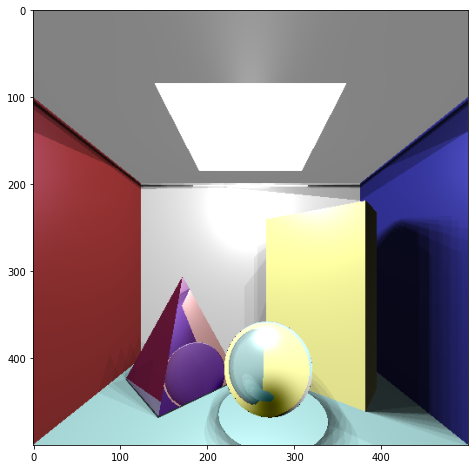

In [72]:

#==============================================================================================

image = np.zeros((height, width, 3))
for i, y in tqdm(enumerate(np.linspace(screen[1], screen[3], height)),total=width):
    for j, x in enumerate(np.linspace(screen[0], screen[2], width)):
        # screen is on origin
        pixel = np.array([x, y, 0])
        origin = camera
        direction = normalize(pixel - origin)  
        color = RecursiveRayTracing(objects,origin,direction,4,1.0,1.0)
        image[i, j] = np.clip(color, 0, 1)
        if TIR == True:
            image[i,j] = np.array([0,1,0])
            TIR = False

#================================================================================================    
imsave('RenderedImage_'+str(width)+'.png',image)

fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.imshow(image)
plt.show()

48

240